In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

In [22]:
n_features = 2
n_latent = 2
sparsity_penalty = 1.0
temperature = 1
sigma = 0.1
dt = 1e-3
lam, pi = 1, 0.3 #Is lambda here the same as sparsity penalty? I just set both to be 1 so it doesnt matter for now.
u0 = - (1/ lam) * np.log(pi) #pi = exp(-lam*u0)
C = lambda s: s.abs().sum()
Cprime = lambda s: torch.sign(s)

def ReLU(x): #Put this function in utils.py
      return torch.maximum(x, torch.zeros_like(x))

class LangevinSparseCoding():
    def __init__(self,
                 n_features:int,
                 n_latent:int,
                 sparsity_penalty:float,
                 temperature:float,
                 dt:float,
                 cost_function,
                 cost_function_grad,
                 momentum:float=0.
                 ):
        self.n_features = n_features
        self.n_latent = n_latent
        self.sparsity_penalty = sparsity_penalty
        self.temperature = torch.FloatTensor([temperature])
        self.dt = torch.FloatTensor([dt])
        self.momentum = momentum
        self.A = torch.tensor([[1., 0.], [0., 1.]])#torch.FloatTensor(n_features, n_latent).normal_()
        self.normalize_dictionary()
        self.cost_function = cost_function
        self.cost_function_grad = cost_function_grad

    def set_temperature(self,temperature:float):
        self.temperature = torch.FloatTensor([temperature])

    def set_dt(self,dt:float):
        self.dt = torch.FloatTensor([dt])

    def energy(self,x,u):
        s = ReLU(torch.abs(u) - u0)
        return 0.5/sigma**2 * ((self.A @ s - x)**2).sum() + self.sparsity_penalty*self.cost_function(u) 

    def p(self,x,s): #Does this need to be modified?
        return torch.exp(-self.energy(x,s)/self.temperature)
    

    def energy_grad(self,x,u):
        s = ReLU(torch.abs(u) - u0)
        return self.A.T@(x-self.A@s)*np.heaviside(torch.abs(u) - u0, 0) - self.sparsity_penalty*self.cost_function_grad(u)


    def first_order_langevin_update(self,x,u):
        return self.dt*(self.energy_grad(x,u)) + torch.sqrt(2*self.temperature*self.dt)*torch.FloatTensor(u.shape).normal_()


    def second_order_langevin_update(self,x,s,v):
        ds = self.dt/self.momentum*v
        dv = -ds + self.first_order_langevin_update(x,s) 
        return ds, dv

    def normalize_dictionary(self):
        with torch.no_grad():
            self.A.div_(torch.norm(self.A,dim=1,keepdim=True))

lsc = LangevinSparseCoding(
    n_features=n_features,
    n_latent=n_latent,
    sparsity_penalty=sparsity_penalty,
    temperature=temperature,
    cost_function = C,
    cost_function_grad = Cprime,
    dt=dt
)

s_star = torch.ones([n_latent,],dtype=torch.float) #change to L0
NOISE_MEAN, NOISE_VARIANCE = 0 , sigma
x = lsc.A@s_star + np.random.normal(NOISE_MEAN, NOISE_VARIANCE)

In [23]:
tmax = int(1e4)
u_inference = torch.ones_like(s_star) #Sample from exponential(lam)
s_inference = ReLU(torch.abs(u_inference) - u0)
energies = []
S = []
U = []
S.append(s_inference.data.numpy().copy())
for n in tqdm(range(tmax)):
    energies.append(lsc.energy(x,u_inference).item())
    u_inference += torch.clone(lsc.first_order_langevin_update(x,u_inference))
    s_inference = ReLU(torch.abs(u_inference) - u0)
    S.append(s_inference.data.numpy().copy())
    U.append(u_inference.data.numpy().copy())
S = np.asarray(S)
U = np.asarray(U)
energies = np.asarray(energies)

100%|██████████| 10000/10000 [00:00<00:00, 14616.83it/s]


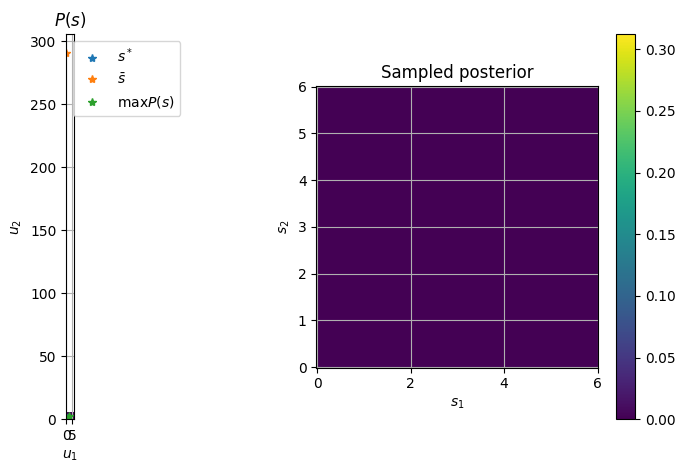

In [24]:
vmax=6
vmin=0
n_bins=200

xlist = np.linspace(vmin, vmax, n_bins)
ylist = np.linspace(vmin, vmax, n_bins)
X, Y = np.meshgrid(xlist, ylist)
Ugrid = np.asarray([X.flatten(),Y.flatten()]).T

Z = np.zeros([Ugrid.shape[0]])
for i in range(len(Z)):
  Z[i] = lsc.p(x,torch.tensor(Ugrid[i,:],dtype=torch.float).abs())
pS_energy_function = Z.reshape(X.shape)
pS_energy_function /= np.sum(pS_energy_function)

pS_emperical, xedges, yedges = np.histogram2d(
    x=S[:,0],
    y=S[:,1],
    bins=n_bins,
    range=[[vmin, vmax], [vmin, vmax]],
    density=True,
)
pS_emperical = pS_emperical.T
pS_emperical /= np.sum(pS_emperical)


vmax_color = np.max([pS_emperical,pS_energy_function])

fig,axs = plt.subplots(1,2,figsize=(10,5))
ax = axs[0]
cp = ax.pcolormesh(X, Y, pS_energy_function, vmax=vmax_color,vmin=0)#,levels)
q = s_star.unsqueeze(0).detach().cpu().numpy().T

ax.plot(*q,'*',label=r'$s^*$')
ax.plot(*S.mean(axis=0,keepdims=True).T,'*',label=r'$\bar{s}$')
ax.plot(*Ugrid[(np.argmax(Z),),:].T,'*',label=r'$\max P(s)$')
ax.set_xlabel(r'$u_1$')
ax.set_ylabel(r'$u_2$')
ax.set_aspect('equal')
ax.legend()
ax.grid()
ax.set_title(r'$P(s)$')

# -----
ax = axs[1]
cp = ax.pcolormesh(X, Y, pS_emperical,vmax=vmax_color,vmin=0)
fig.colorbar(cp)
ax.set_xlabel(r'$s_1$')
ax.set_ylabel(r'$s_2$')
ax.grid()
ax.set_title(r'Sampled posterior')
ax.set_aspect('equal')

Text(0.5, 0, 'u_2')

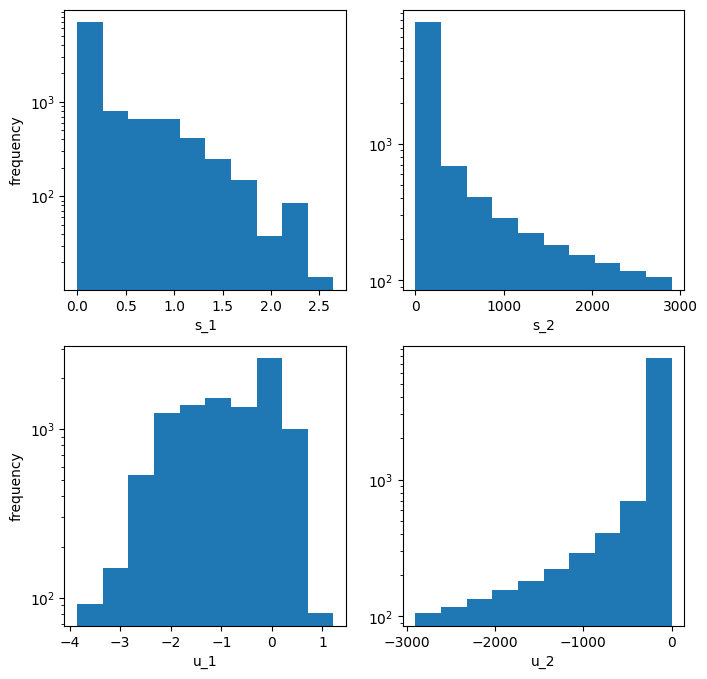

In [29]:
fig,axs = plt.subplots(2,2,figsize=(8,8))
ax = axs[0,0]
ax.hist(S[:,0])
ax.set_yscale('log')
ax.set_xlabel('s_1')
ax.set_ylabel('frequency')

ax = axs[0,1]
ax.hist(S[:,1])
ax.set_yscale('log')
ax.set_xlabel('s_2')
# ax.set_ylabel('frequency')

ax = axs[1,0]
ax.hist(U[:,0])
ax.set_yscale('log')
ax.set_xlabel('u_1')
ax.set_ylabel('frequency')

ax = axs[1,1]
ax.hist(U[:,1])
ax.set_yscale('log')
ax.set_xlabel('u_2')
# ax.set_ylabel('frequency')